In [1]:
suppressPackageStartupMessages({
    library(Seurat)
    library(SeuratDisk)
    library(scCustomize) 
    library(SCP)
    library(ggplot2)
    library(dplyr)
    library(knitr)
    library(readr) 
    library(ggsci)
    library(scater)
    library(DoubletFinder)
    library(Trex)    
    library(SCpubr)
    library(biomaRt)
    library(data.table)
    library(genekitr)
    library(Azimuth)
    library(UCell)
    library(harmony)

    load("data/cycle.rda")
    source('helper_functions.R')
    
})


options(future.globals.maxSize = 128*1024**3)
plan(strategy = "multicore", workers = 1)
plan()

set.seed(123)

multicore:
- args: function (..., workers = 1, envir = parent.frame())
- tweaked: TRUE
- call: plan(strategy = "multicore", workers = 1)

In [2]:
prepost <- readRDS("../ProcessedData/seurat/filtered_prepost_csf.rds")

In [ ]:
prepost <- preprocess_seurat_object(prepost,  g2m_genes, s_genes, nfeatures = 2000, phase_threshold = 1)

In [ ]:
prepost <- RunHarmony(prepost, 'Batch', verbose = FALSE)

In [ ]:

prepost <- FindNeighbors(prepost, reduction = "harmony", dims = 1:30)
prepost <- FindClusters(prepost, resolution = .5, cluster.name = "harmony_clusters", algorithm = 1)

In [ ]:
summary_stats <- prepost@meta.data %>%
  group_by(harmony_clusters) %>%
  summarize(
    num_cells = n(),
    median_nUMI = median(nCount_RNA),
    median_nGene = median(nFeature_RNA),
    median_percent_mt = round(median(percent.mt),2),
    median_percent_ribo = round(median(percent.ribo),2)
  )
kable((summary_stats), format = "markdown")

In [ ]:
prepost <- FindNeighbors(prepost, reduction = "harmony", dims = 1:50)

In [14]:
prepost <- FindClusters(prepost, resolution = 2, cluster.name = "harmony_clusters", algorithm = 1)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 95639
Number of edges: 3252683

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8362
Number of communities: 49
Elapsed time: 20 seconds


1 singletons identified. 48 final clusters.



In [ ]:
prepost <- RunUMAP(prepost, reduction = "harmony", dims = 1:50, verbose=F, reduction.name = "umap.harmony", 
                   spread=1, min.dist=.3, n.neighbors = 40, metric='cosine')

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 9, repr.plot.res=200)
CellDimPlot(srt = prepost, group.by = c( "harmony_clusters"), 
    label=T, label_insitu=T, label.fg = "black", label.bg = "white", label.bg.r = 0,label.size =2.8, label_repel = F, pt.size=0.1,
    ncol=1, reduction = "umap.harmony") & xlab('UMAP 1')  & ylab('UMAP 2')


In [ ]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res=200)
FeatureDimPlot(prepost, features = c('CAR'),  ncol=3,reduction = "umap.harmony", show_stat=F, 
               label = F, pt.size=0.001) & xlab('UMAP 1') & ylab('UMAP 2')

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's fill values."


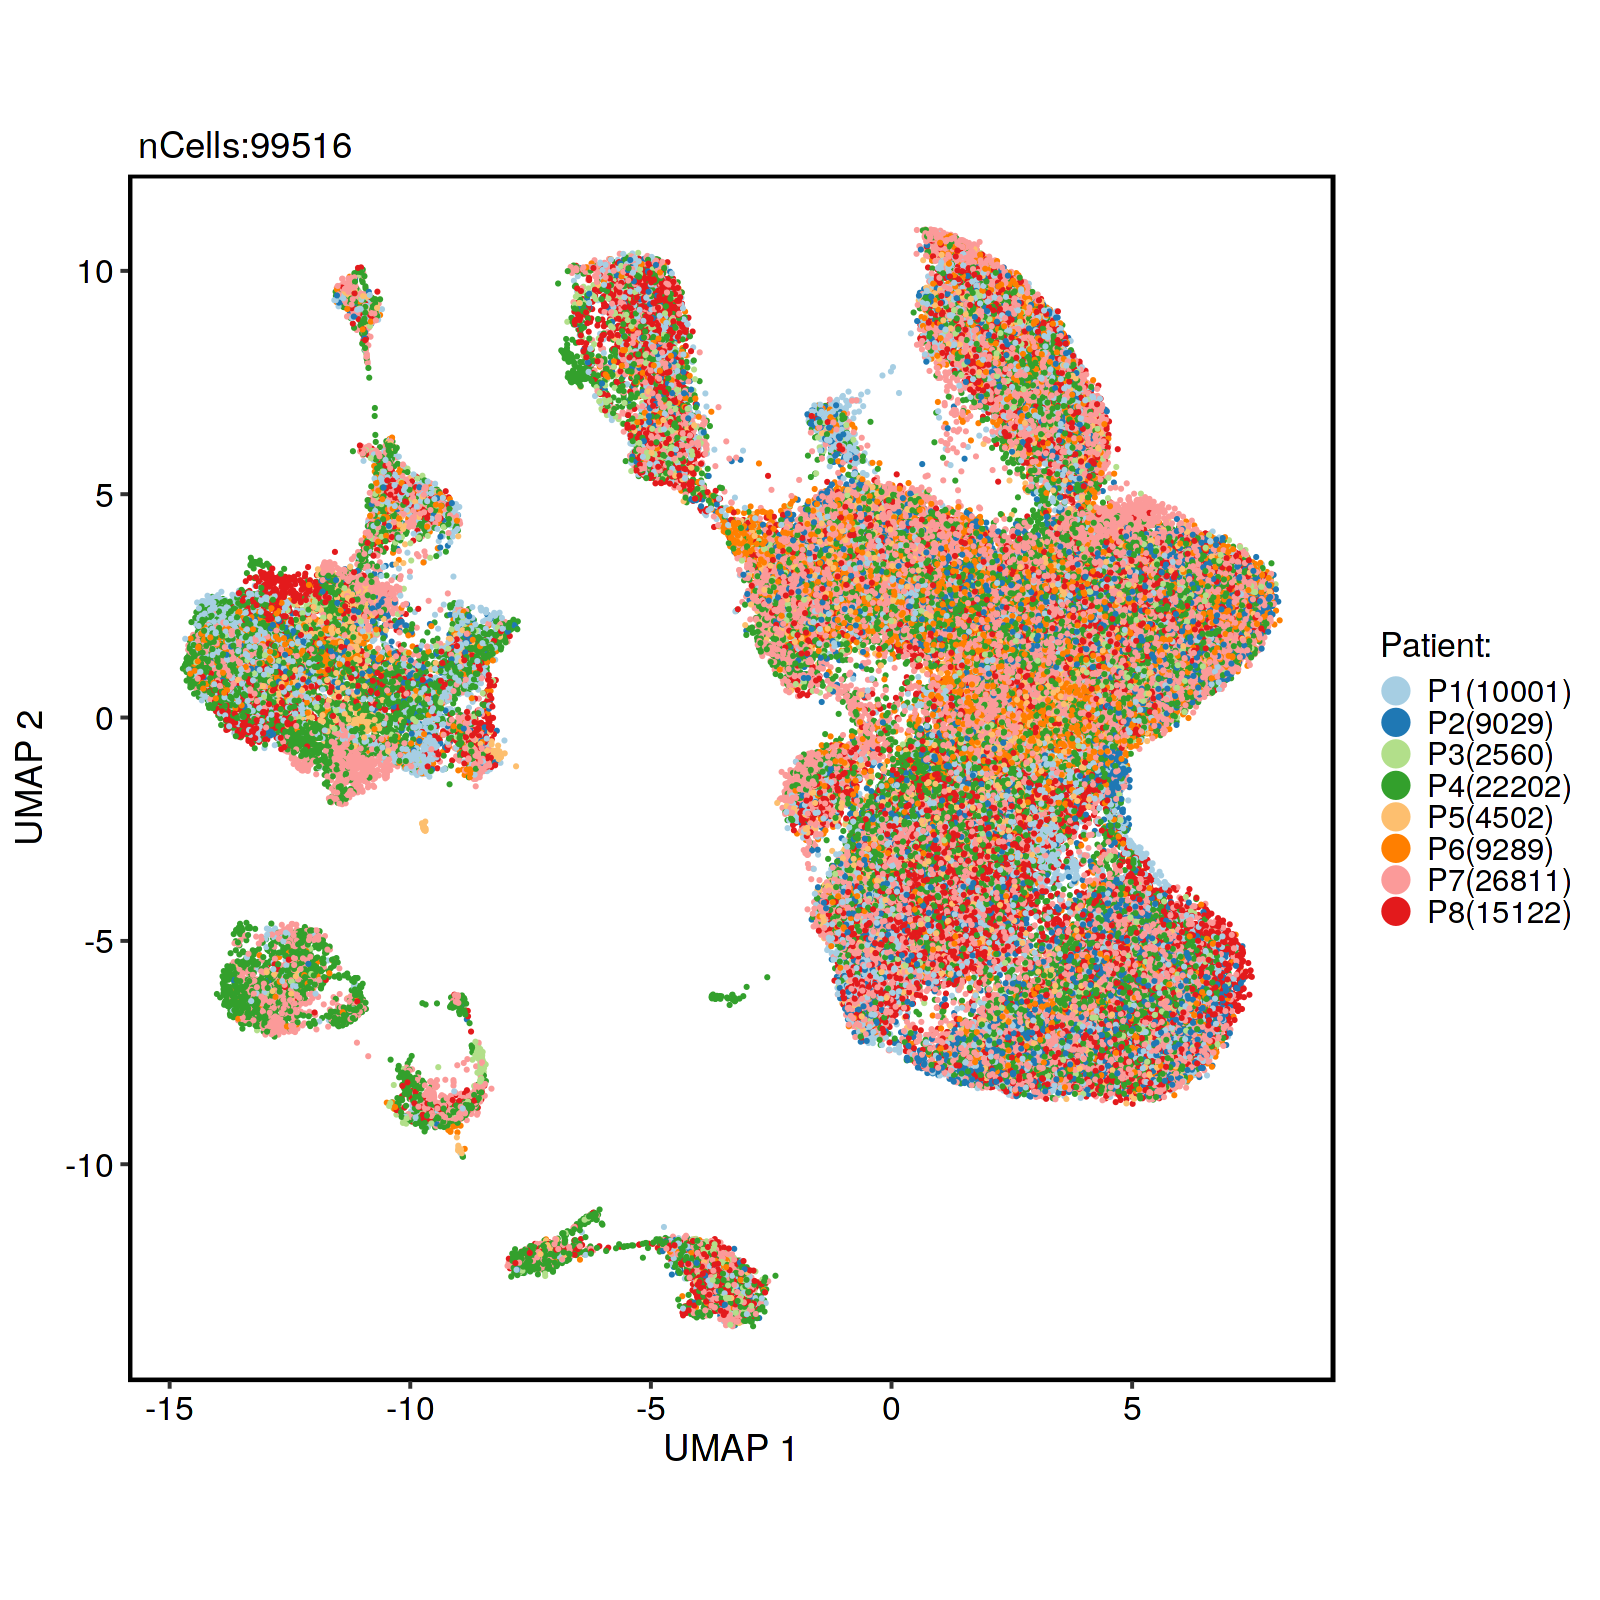

In [97]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res=200)
CellDimPlot(srt = prepost, group.by = c( "Patient"), 
    label=F, label.size =2.8, label_repel = F, pt.size=0.1,
    ncol=1, reduction = "umap.harmony") & xlab('UMAP 1')  & ylab('UMAP 2')


#### Identify and remove doublets

##### Srublet Doublets

In [128]:
scrublet = read.csv('results/scrublet_doublets.csv')
rownames(scrublet) <- scrublet$X
scrublet <- scrublet[c('doublet_score', 'predicted_doublet')]
prepost <- AddMetaData(prepost, scrublet)

In [131]:
prepost$doublet_threshold = (prepost$doublet_score > 0.2)

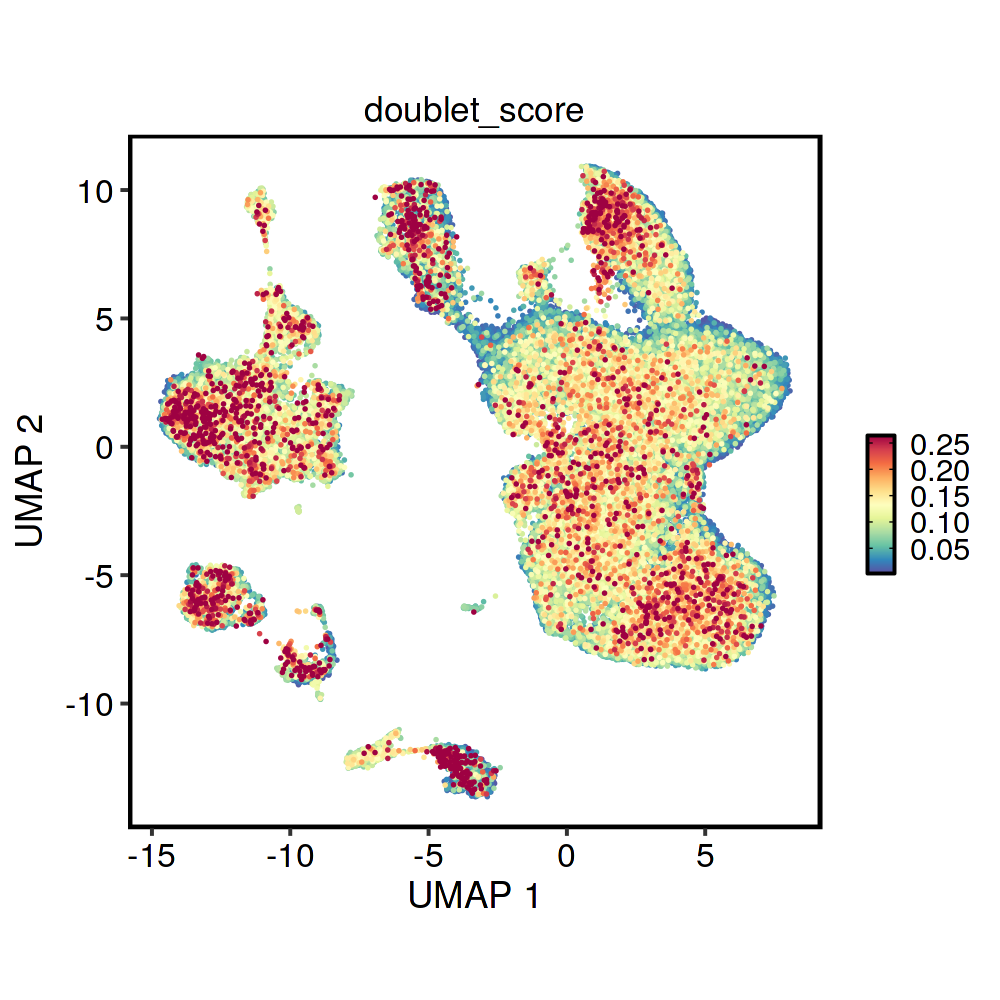

In [133]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res=200)
FeatureDimPlot(prepost, features = c('doublet_score'),  ncol=3,reduction = "umap.harmony", show_stat=F, 
               label = F, pt.size=0.001) & xlab('UMAP 1') & ylab('UMAP 2')

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."
Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."


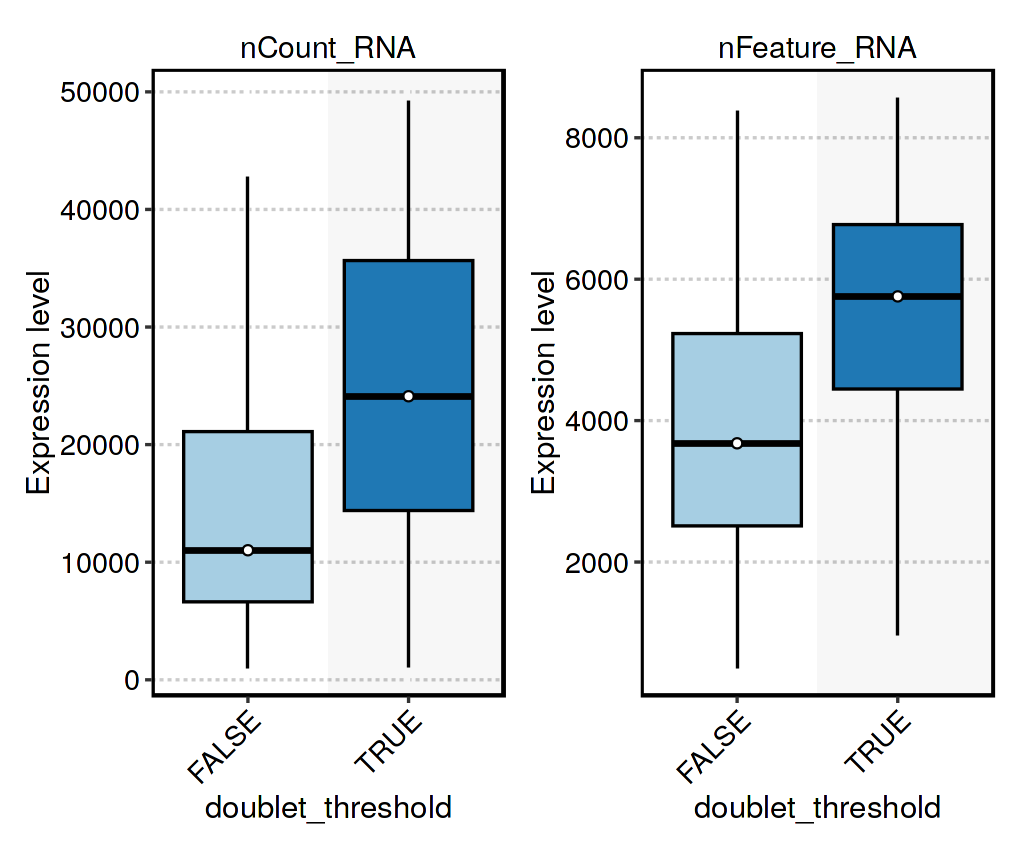

In [157]:
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res=170)
FeatureStatPlot(prepost, group.by = "doublet_threshold", stat.by = c("nCount_RNA", "nFeature_RNA"),
                plot_type='box', legend.position='none')

In [163]:
prepost <- subset(prepost, doublet_score < 0.2)

##### TCR Doublets

In [165]:
prepost <- FindClusters(prepost, resolution = 0.1, cluster.name = "harmony_clusters_0.1", algorithm = 1)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 97195
Number of edges: 3193512

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9700
Number of communities: 12
Elapsed time: 28 seconds


Warning message:
"Adding a command log without an assay associated with it"


Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's fill values."


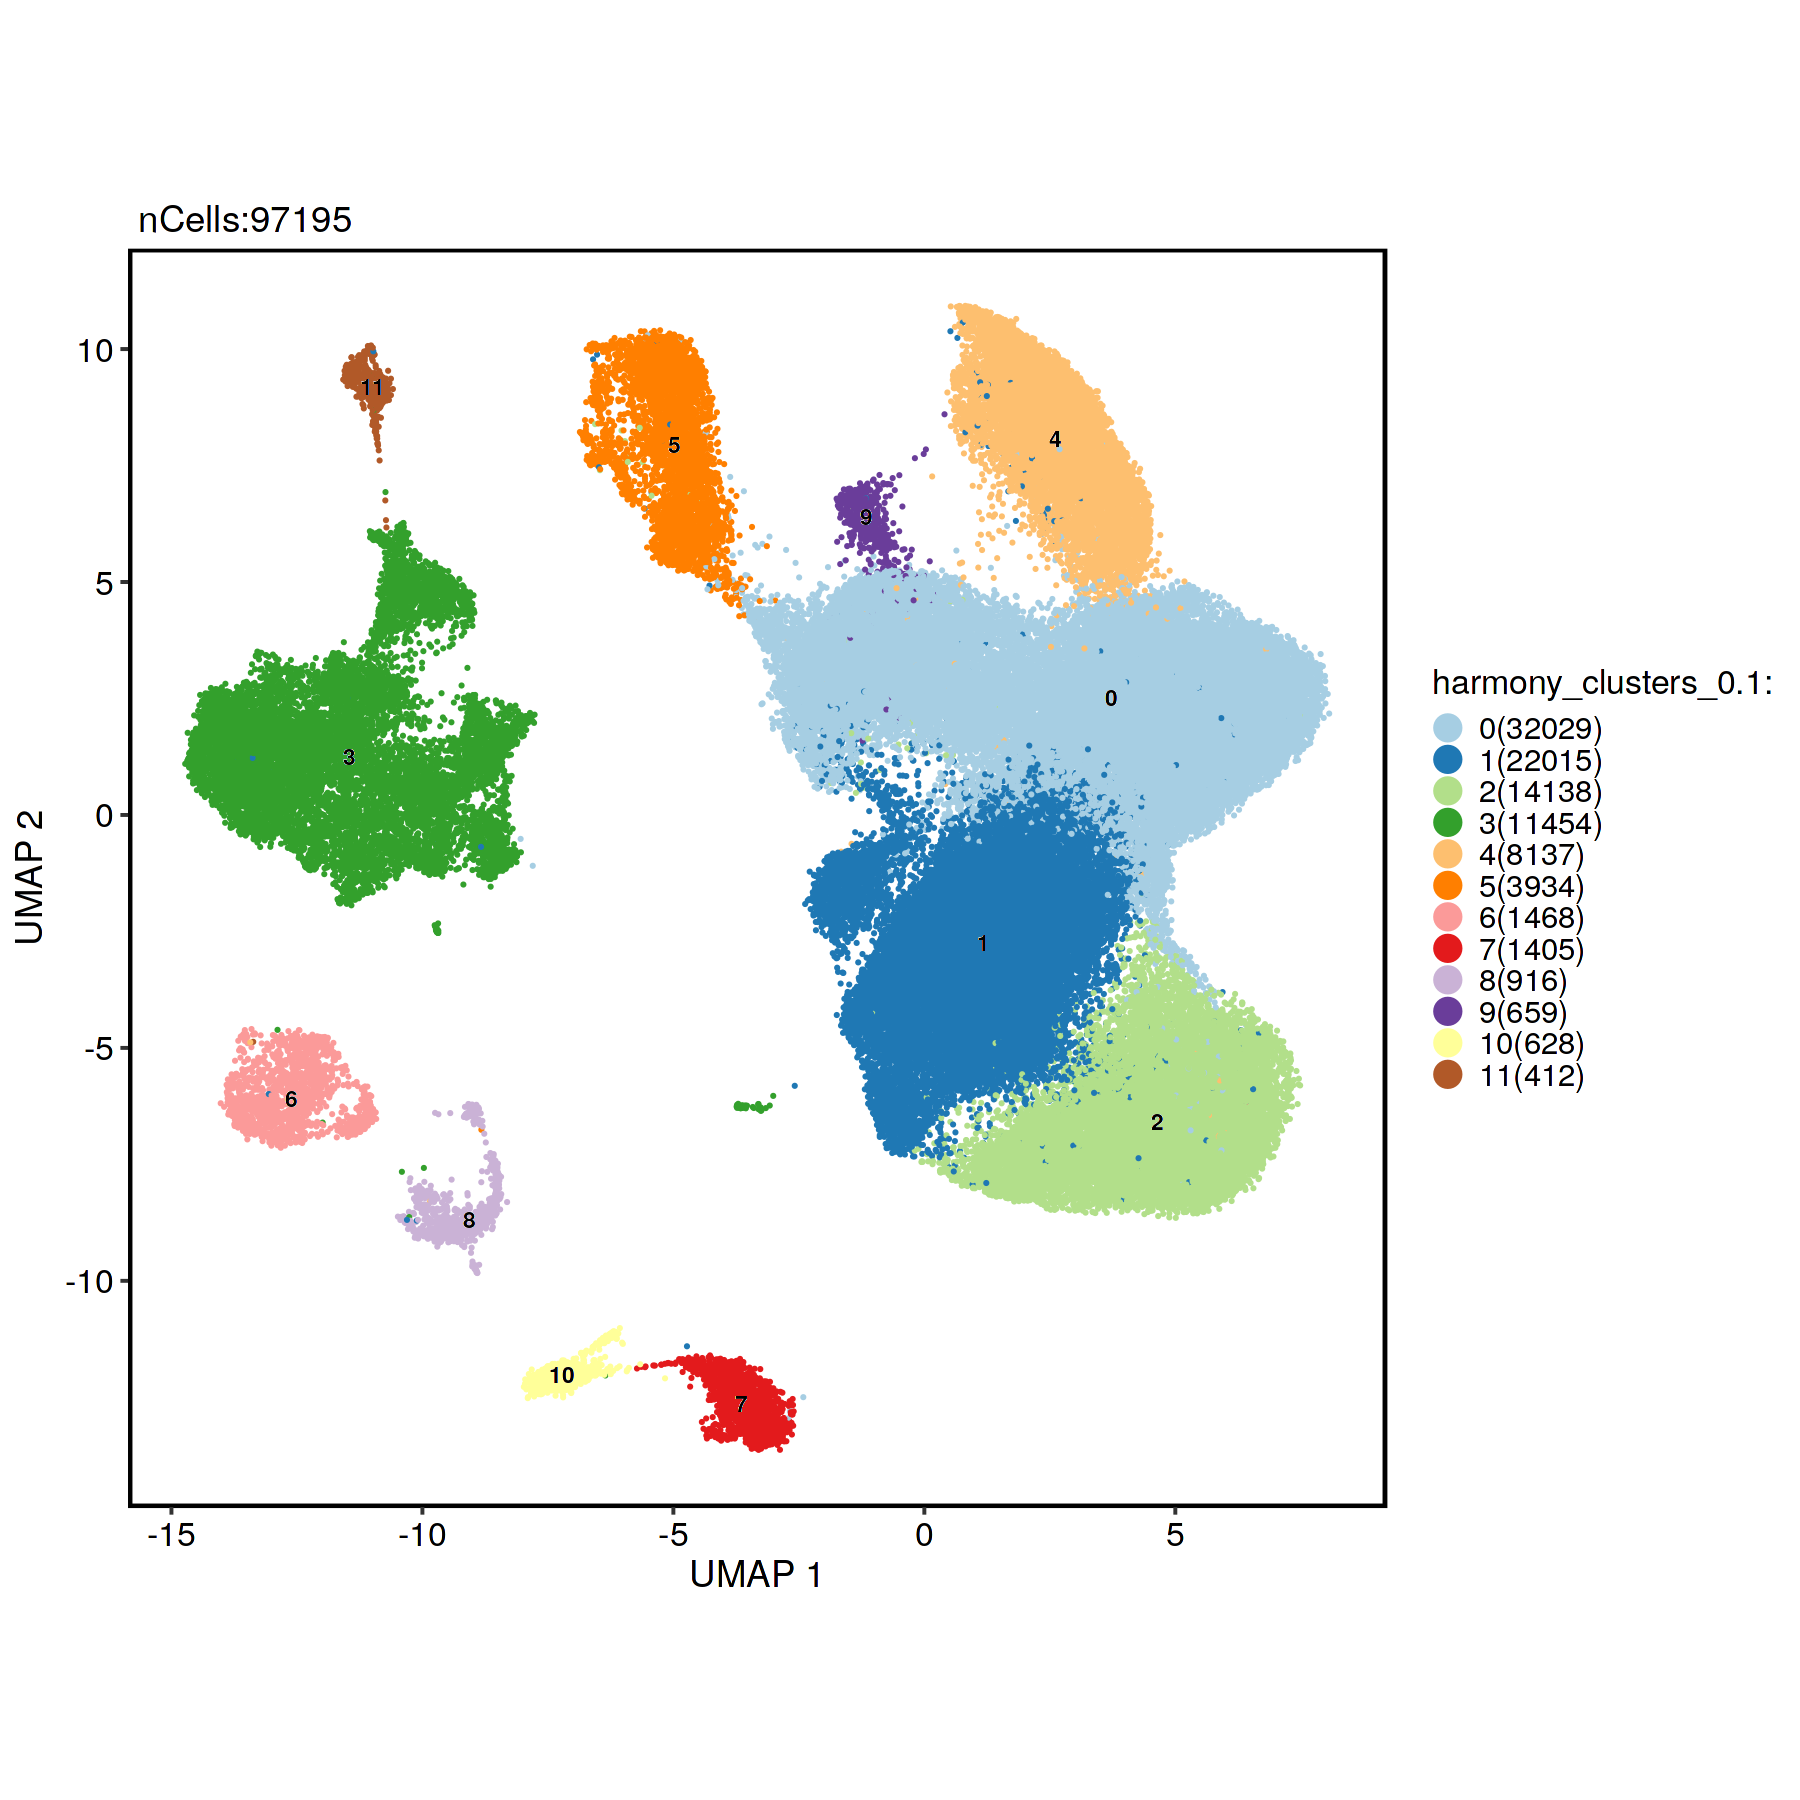

In [166]:
options(repr.plot.width = 9, repr.plot.height = 9, repr.plot.res=200)
CellDimPlot(srt = prepost, group.by = c( "harmony_clusters_0.1"), 
    label=T, label_insitu=T, label.fg = "black", label.bg = "white", label.bg.r = 0,label.size =2.8, label_repel = F, pt.size=0.1,
    ncol=1, reduction = "umap.harmony") & xlab('UMAP 1')  & ylab('UMAP 2')

In [167]:
Idents(prepost) <- prepost$harmony_clusters_0.1
prepost <- RenameIdents(prepost, 
       "0" = "0. T",
       "1" = "1. T",
       "2" = "2. T",
       "3" = "3. Myeloid",
       "4" = "4. T",
       "5" = "5. NK",
       "6" = "6. Myeloid", 
       "7" = "7. B",
       "8" = "8. Myeloid",
       "9" = "9. T",
       "10" = "10. Plasma",
       "11" = "11. Myeloid" 
)
prepost$cell_type_clust <- Idents(prepost)

In [168]:
prepost$cell_type <- sub("^\\d+\\.\\s*", "", prepost$cell_type_clust)

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's fill values."


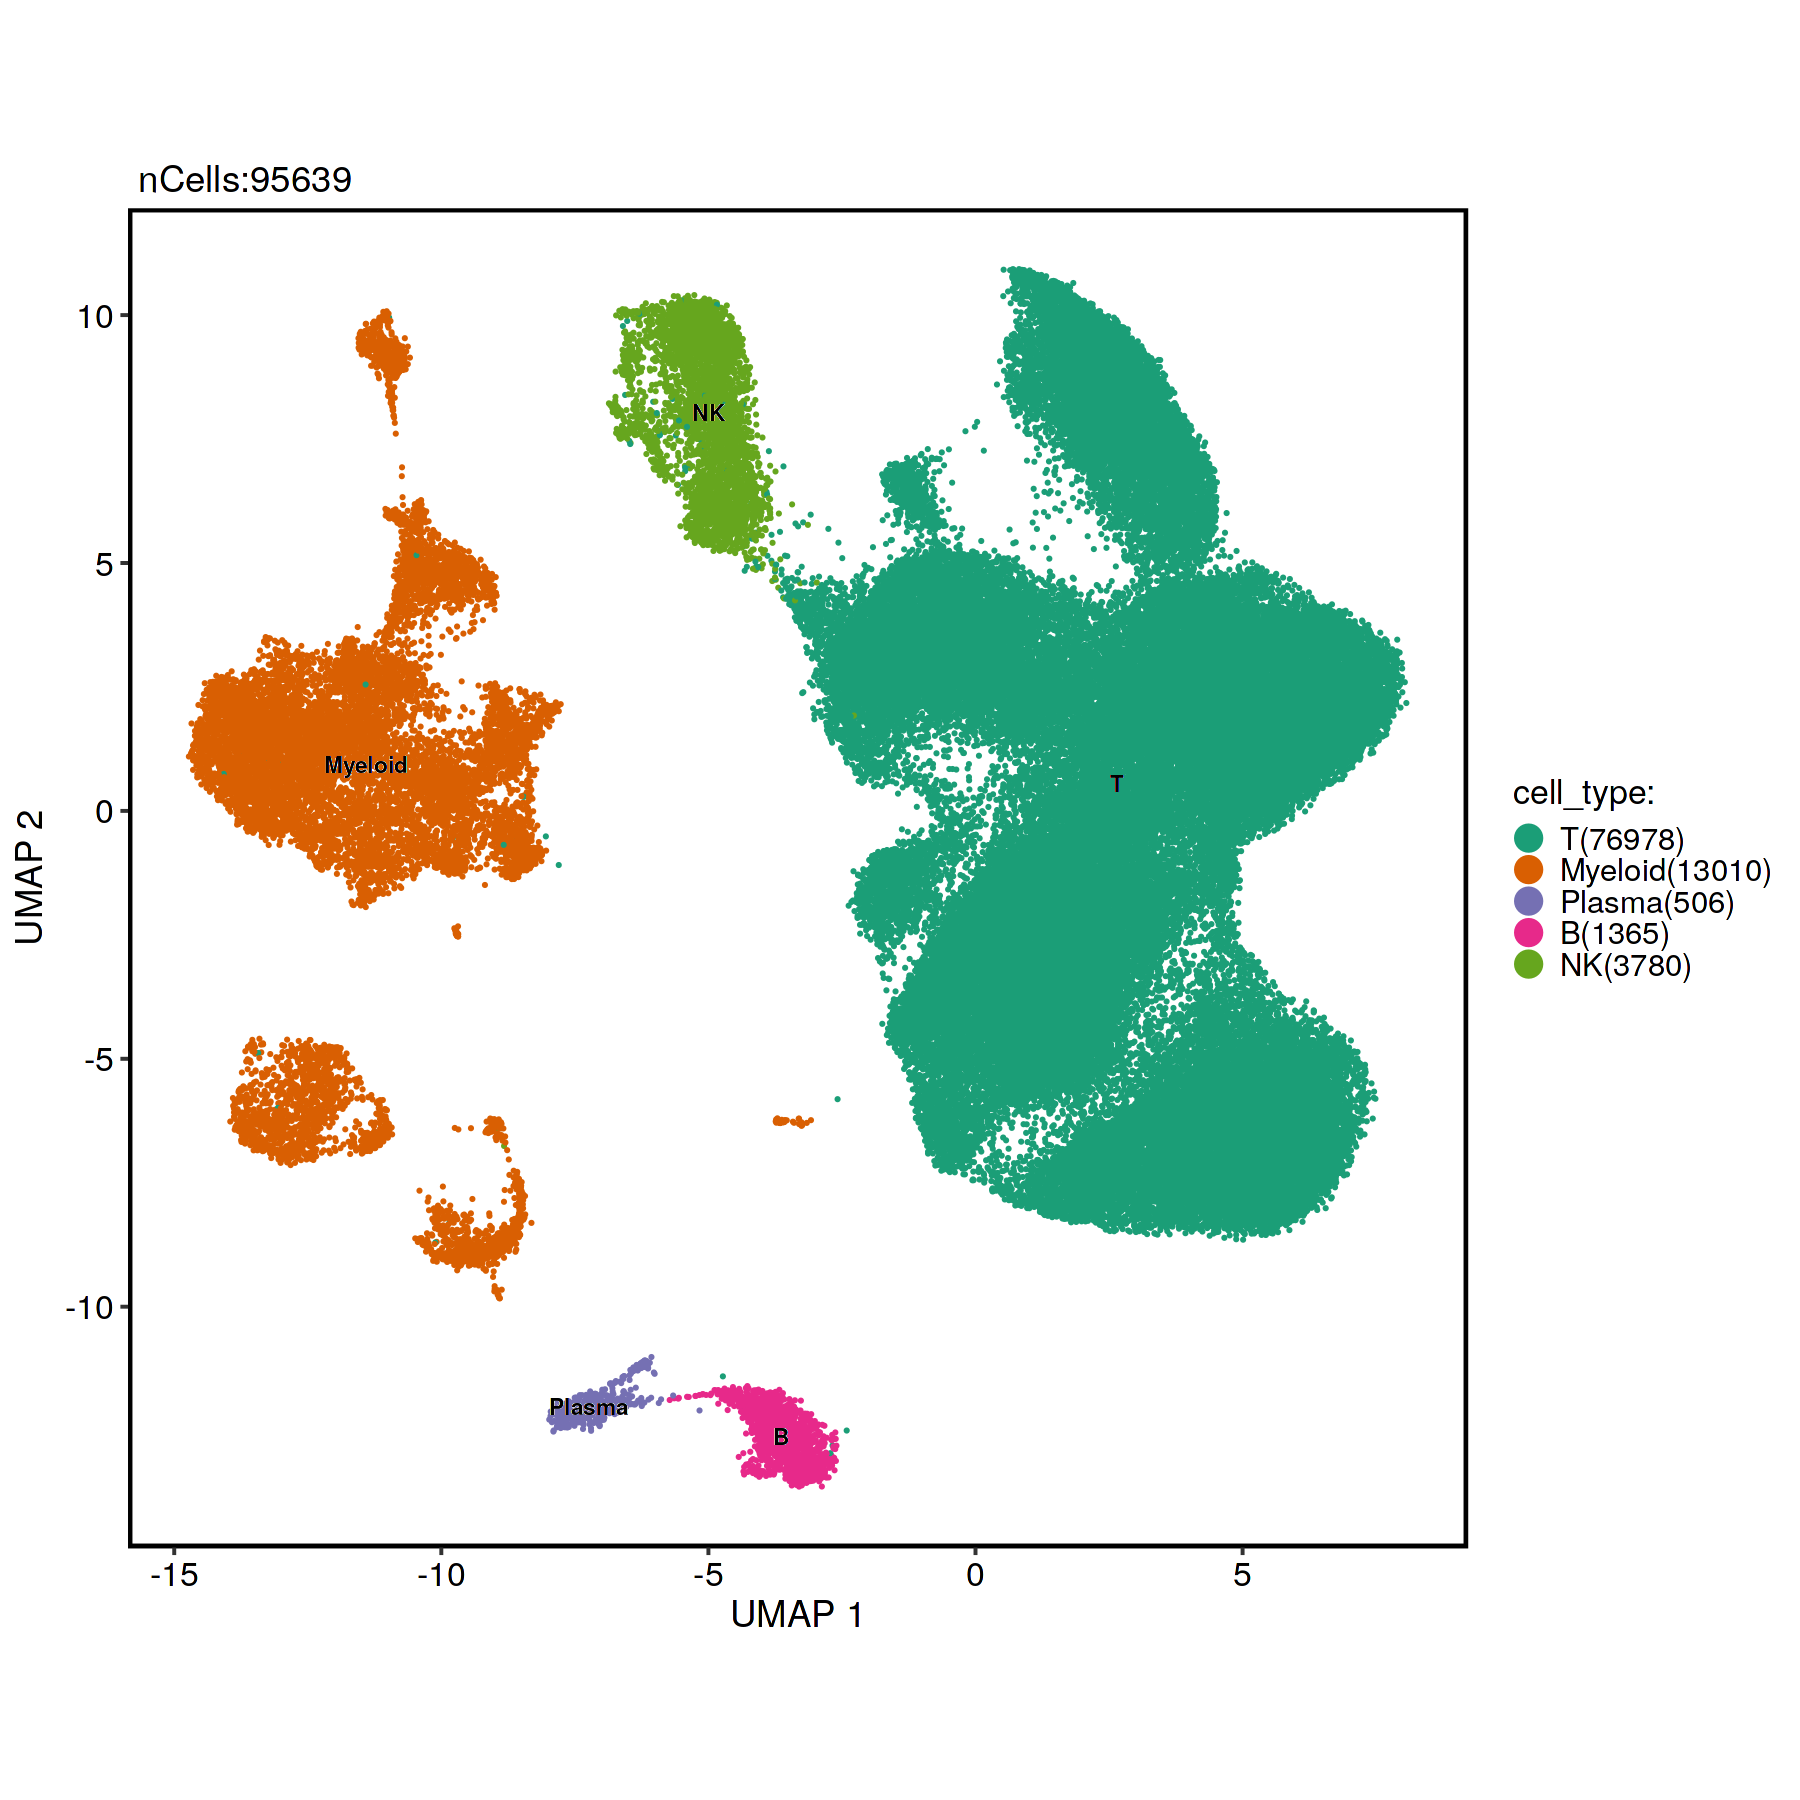

In [210]:
options(repr.plot.width = 9, repr.plot.height = 9, repr.plot.res=200)
CellDimPlot(srt = prepost, group.by = c( "cell_type"), palette='Dark2',
    label=T, label_insitu=T, label.fg = "black", label.bg = "white", label.bg.r = 0,label.size =2.8, label_repel = F, pt.size=0.1,
    ncol=1, reduction = "umap.harmony") & xlab('UMAP 1')  & ylab('UMAP 2')


In [170]:
prepost$hasTCR <- !is.na(prepost$cloneSize)

prepost$TCR <- 'TCR_present'
prepost$TCR[is.na(prepost$cloneSize)] <- 'TCR_absent'

In [171]:
table(prepost$cell_type, prepost$TCR)

         
          TCR_absent TCR_present
  B             1365          40
  Myeloid      13010        1240
  NK            3780         154
  Plasma         506         122
  T             7625       69353

In [172]:
prepost$nonTcell_hasTCR <- prepost$hasTCR & prepost$cell_type != 'T'

In [173]:
prepost$cell_type_hasTCR <- paste0(prepost$cell_type, '_', prepost$TCR)

In [175]:
Idents(prepost) <- 'cell_type_hasTCR'

Warning message:
"Scaling data with a low number of groups may produce misleading results"


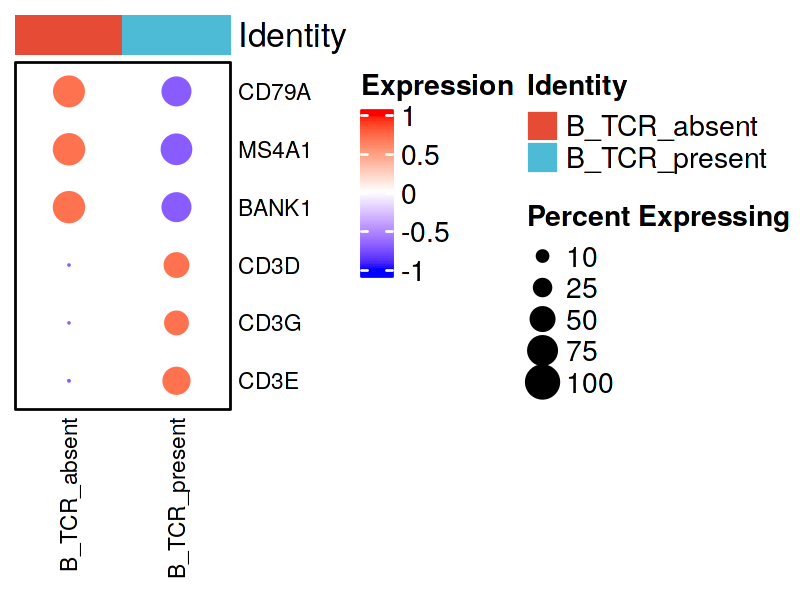

In [176]:
options(repr.plot.width=4, repr.plot.height=3, repr.plot.res=200)
P <- Clustered_DotPlot(subset(prepost, cell_type == 'B'),  features = c('CD79A', 'MS4A1', 'BANK1', 'CD3D','CD3G', 'CD3E'), k = 1, x_lab_rotate=90,
        cluster_feature = F, cluster_ident = F, flip=F, exp_color_max=1, exp_color_min=-1, 
        colors_use_idents=pal_npg()(3), colors_use_exp = CustomPalette(low = "blue", high = "red", mid = 'white', k = 10)) #+ mytheme 

Warning message:
"Scaling data with a low number of groups may produce misleading results"


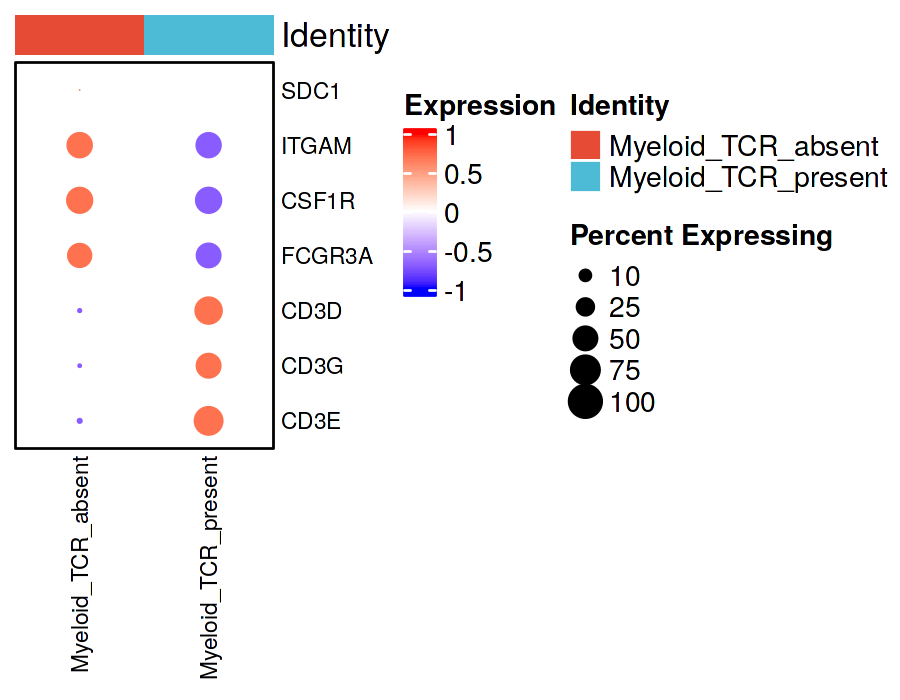

In [184]:
options(repr.plot.width=4.5, repr.plot.height=3.5, repr.plot.res=200)
P <- Clustered_DotPlot(subset(prepost, cell_type == 'Myeloid'),  features = c('ITGAM', 'CSF1R', 'FCGR3A', 'CD3D','CD3G', 'CD3E'), k = 1, x_lab_rotate=90,
        cluster_feature = F, cluster_ident = F, flip=F, exp_color_max=1, exp_color_min=-1, 
        colors_use_idents=pal_npg()(3), colors_use_exp = CustomPalette(low = "blue", high = "red", mid = 'white', k = 10)) #+ mytheme 

Warning message:
"Scaling data with a low number of groups may produce misleading results"


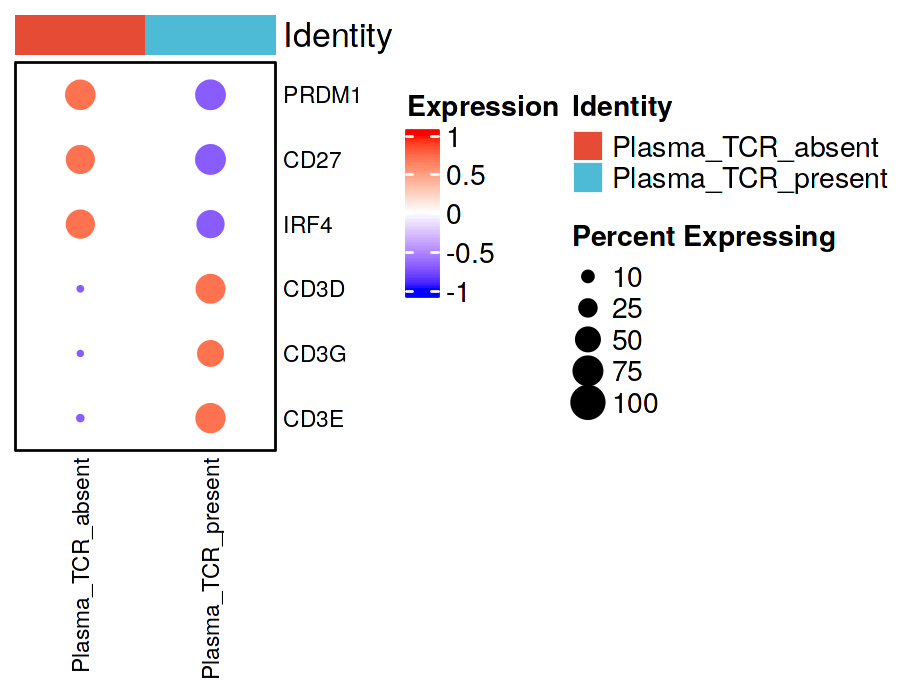

In [188]:
options(repr.plot.width=4.5, repr.plot.height=3.5, repr.plot.res=200)
P <- Clustered_DotPlot(subset(prepost, cell_type == 'Plasma'),  features = c('PRDM1','CD27', 'IRF4', 'CD3D','CD3G', 'CD3E'), k = 1, x_lab_rotate=90,
        cluster_feature = F, cluster_ident = F, flip=F, exp_color_max=1, exp_color_min=-1, 
        colors_use_idents=pal_npg()(3), colors_use_exp = CustomPalette(low = "blue", high = "red", mid = 'white', k = 10)) #+ mytheme 

In [189]:
prepost <- subset(prepost, nonTcell_hasTCR == FALSE)

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's fill values."


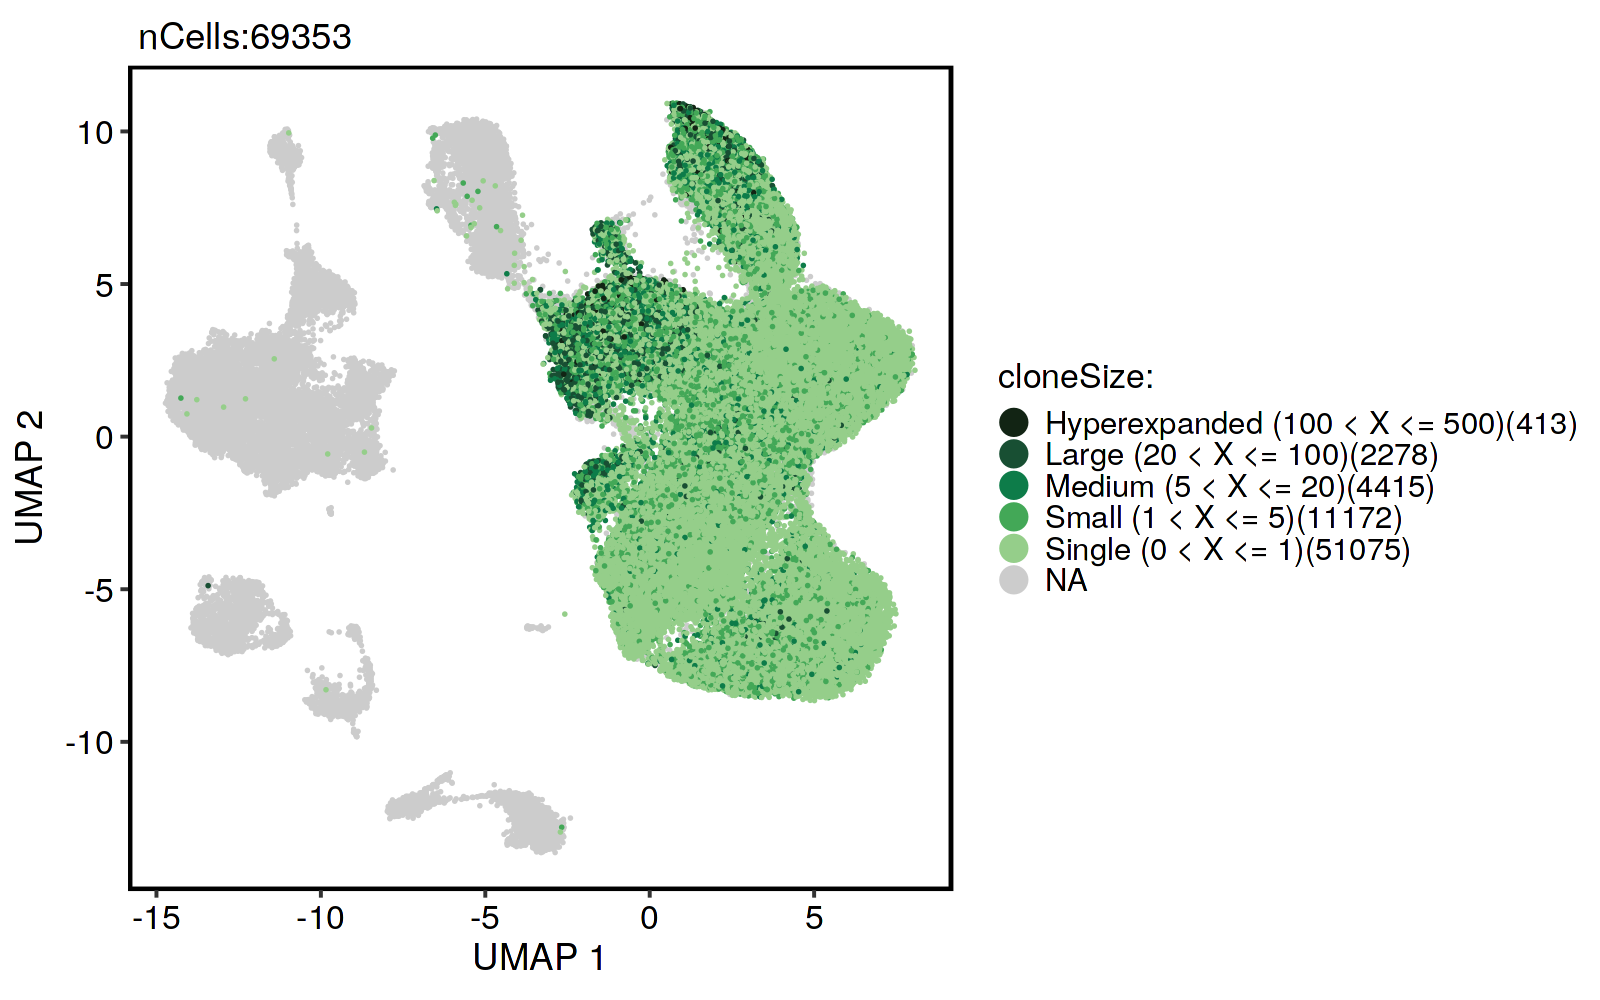

In [212]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res=200)
CellDimPlot(srt = prepost, group.by = c( "cloneSize"), 
    label=F, label.size =2.8, label_repel = F, pt.size=0.01, palette='ocean.algae',
    ncol=1, reduction = "umap.harmony") & xlab('UMAP 1')  & ylab('UMAP 2')


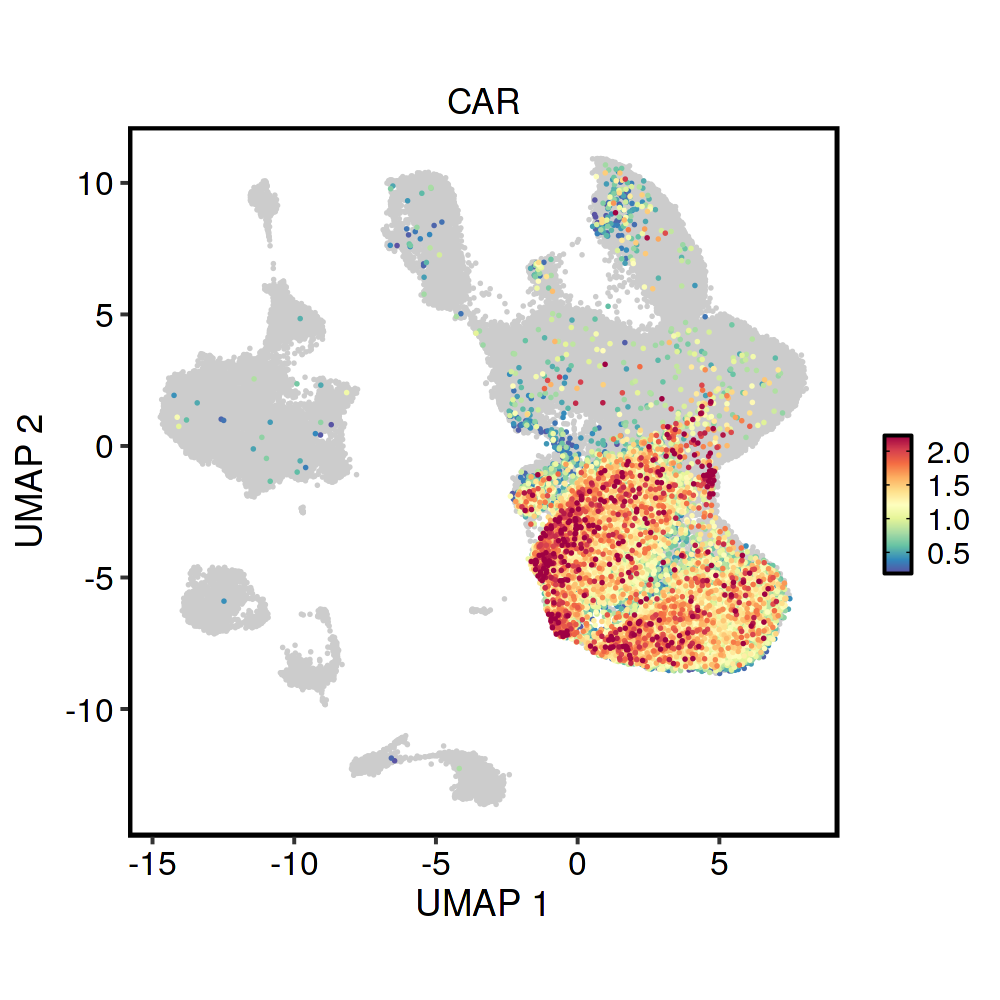

In [229]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res=200)
FeatureDimPlot(prepost, features = c('CAR'),  ncol=3,reduction = "umap.harmony", show_stat=F, 
               label = F, pt.size=0.001) & xlab('UMAP 1') & ylab('UMAP 2')

In [ ]:
prepost$Day[prepost$Day == 'D0_run2'] = 'D0'
prepost <- subset(prepost, Day != 'D28')
prepost$sample_id[prepost$sample_id == 'P5D0_run2'] = 'P5D0'

In [230]:
saveRDS(prepost, "../ProcessedData/seurat/filtered_prepost_csf.rds")